In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

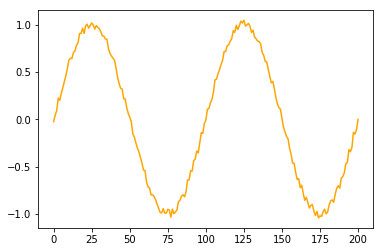

In [3]:
T = 100
f = toy_problem(T)
plt.plot(f, color='orange')
plt.show()

In [4]:
length_of_sequences = 2 * T  # 全時系列の長さ
maxlen = 25  # １つの時系列の長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [5]:
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

In [6]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

# TensorFlowによる実装

In [7]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.GRUCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    state = initial_state
    outputs = []  # 過去の隠れ層の出力を保存
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c  # 線形活性
    return y

In [8]:
def loss(y, t):
    return tf.reduce_mean(tf.square(y-t))

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    
    train_step = optimizer.minimize(loss)
    return train_step

In [9]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [10]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

In [11]:
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])

In [12]:
y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)

In [13]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size
early_stopping = EarlyStopping(patience=10, verbose=1)


for epoch in range(epochs):
        X_, Y_ = shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                n_batch: batch_size
                })
            
            val_loss = loss.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                n_batch: N_validation
            })   
            
            # 値を記録しておく
            print('epoch: ', epoch,
                 ' validation loss: ', val_loss)
            
            if early_stopping.validate(val_loss):
                break

epoch:  0  validation loss:  0.517298
epoch:  0  validation loss:  0.514171
epoch:  0  validation loss:  0.510813
epoch:  0  validation loss:  0.507621
epoch:  0  validation loss:  0.50455
epoch:  0  validation loss:  0.50148
epoch:  0  validation loss:  0.498444
epoch:  0  validation loss:  0.495536
epoch:  0  validation loss:  0.492526
epoch:  0  validation loss:  0.489303
epoch:  0  validation loss:  0.485903
epoch:  0  validation loss:  0.482337
epoch:  0  validation loss:  0.478556
epoch:  0  validation loss:  0.474656
epoch:  0  validation loss:  0.47054
epoch:  1  validation loss:  0.46624
epoch:  1  validation loss:  0.461783
epoch:  1  validation loss:  0.457144
epoch:  1  validation loss:  0.452228
epoch:  1  validation loss:  0.44705
epoch:  1  validation loss:  0.441719
epoch:  1  validation loss:  0.436132
epoch:  1  validation loss:  0.430157
epoch:  1  validation loss:  0.424007
epoch:  1  validation loss:  0.41773
epoch:  1  validation loss:  0.411297
epoch:  1  validat

epoch:  18  validation loss:  0.00535441
epoch:  19  validation loss:  0.00478451
epoch:  19  validation loss:  0.00436496
epoch:  19  validation loss:  0.00421728
epoch:  19  validation loss:  0.00426851
epoch:  19  validation loss:  0.00454387
epoch:  19  validation loss:  0.00508259
epoch:  19  validation loss:  0.00507412
epoch:  19  validation loss:  0.00473778
epoch:  19  validation loss:  0.00426652
epoch:  19  validation loss:  0.00395531
epoch:  19  validation loss:  0.00377074
epoch:  19  validation loss:  0.00366081
epoch:  19  validation loss:  0.00374849
epoch:  19  validation loss:  0.0039098
epoch:  19  validation loss:  0.00409044
epoch:  20  validation loss:  0.00415652
epoch:  20  validation loss:  0.0041586
epoch:  20  validation loss:  0.00412601
epoch:  20  validation loss:  0.00411028
epoch:  20  validation loss:  0.00407688
epoch:  20  validation loss:  0.00412873
epoch:  20  validation loss:  0.00420038
epoch:  20  validation loss:  0.00426924
early stopping
epo

epoch:  80  validation loss:  0.00151913
epoch:  80  validation loss:  0.00158209
epoch:  80  validation loss:  0.00166156
epoch:  80  validation loss:  0.00171884
epoch:  80  validation loss:  0.00177338
epoch:  80  validation loss:  0.00178905
epoch:  80  validation loss:  0.00173996
epoch:  80  validation loss:  0.00167792
epoch:  80  validation loss:  0.00166632
epoch:  80  validation loss:  0.0016627
early stopping
epoch:  81  validation loss:  0.001708
early stopping
epoch:  82  validation loss:  0.00179573
early stopping
epoch:  83  validation loss:  0.0017679
early stopping
epoch:  84  validation loss:  0.00171735
early stopping
epoch:  85  validation loss:  0.00174495
early stopping
epoch:  86  validation loss:  0.0017676
early stopping
epoch:  87  validation loss:  0.00177444
early stopping
epoch:  88  validation loss:  0.00178535
early stopping
epoch:  89  validation loss:  0.00173556
early stopping
epoch:  90  validation loss:  0.0016768
early stopping
epoch:  91  validatio

epoch:  194  validation loss:  0.000996618
epoch:  194  validation loss:  0.00105806
epoch:  194  validation loss:  0.00108314
epoch:  194  validation loss:  0.00111217
epoch:  194  validation loss:  0.00119881
epoch:  194  validation loss:  0.00131564
epoch:  194  validation loss:  0.00134672
epoch:  194  validation loss:  0.00133027
epoch:  194  validation loss:  0.00115733
epoch:  194  validation loss:  0.000997448
early stopping
epoch:  195  validation loss:  0.000853273
epoch:  195  validation loss:  0.00078807
epoch:  195  validation loss:  0.000827176
epoch:  195  validation loss:  0.000922321
epoch:  195  validation loss:  0.00108852
epoch:  195  validation loss:  0.00126089
epoch:  195  validation loss:  0.00125527
epoch:  195  validation loss:  0.00108384
epoch:  195  validation loss:  0.00089966
epoch:  195  validation loss:  0.000800897
epoch:  195  validation loss:  0.000872624
epoch:  195  validation loss:  0.00107787
epoch:  195  validation loss:  0.00137807
early stoppi

epoch:  320  validation loss:  0.00104211
early stopping
epoch:  321  validation loss:  0.00112772
early stopping
epoch:  322  validation loss:  0.00116038
early stopping
epoch:  323  validation loss:  0.00113287
early stopping
epoch:  324  validation loss:  0.00108632
early stopping
epoch:  325  validation loss:  0.000986547
early stopping
epoch:  326  validation loss:  0.000922066
early stopping
epoch:  327  validation loss:  0.000860431
early stopping
epoch:  328  validation loss:  0.000868074
early stopping
epoch:  329  validation loss:  0.000867351
early stopping
epoch:  330  validation loss:  0.000886757
early stopping
epoch:  331  validation loss:  0.000906809
early stopping
epoch:  332  validation loss:  0.00089865
early stopping
epoch:  333  validation loss:  0.000875806
early stopping
epoch:  334  validation loss:  0.000855393
early stopping
epoch:  335  validation loss:  0.000861351
early stopping
epoch:  336  validation loss:  0.000890938
early stopping
epoch:  337  validat

epoch:  465  validation loss:  0.000972063
early stopping
epoch:  466  validation loss:  0.00090986
early stopping
epoch:  467  validation loss:  0.000915698
early stopping
epoch:  468  validation loss:  0.000964763
early stopping
epoch:  469  validation loss:  0.00103516
early stopping
epoch:  470  validation loss:  0.00110108
early stopping
epoch:  471  validation loss:  0.0011015
early stopping
epoch:  472  validation loss:  0.00104643
early stopping
epoch:  473  validation loss:  0.000945436
early stopping
epoch:  474  validation loss:  0.000880743
early stopping
epoch:  475  validation loss:  0.000909084
early stopping
epoch:  476  validation loss:  0.00104443
early stopping
epoch:  477  validation loss:  0.00117921
early stopping
epoch:  478  validation loss:  0.00125282
early stopping
epoch:  479  validation loss:  0.00144241
early stopping
epoch:  480  validation loss:  0.00161368
early stopping
epoch:  481  validation loss:  0.00175158
early stopping
epoch:  482  validation lo

In [14]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [15]:
for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:],
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
    (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

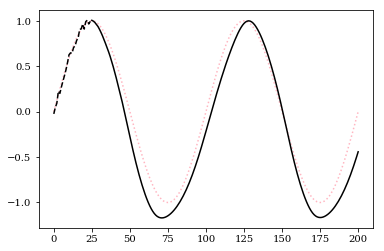

In [16]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# Kerasによる実装

In [17]:
from keras.optimizers import Adam
from keras.layers import Dense, Activation
from keras.layers.recurrent import GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [18]:
def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

In [19]:
model = Sequential()
model.add(GRU(n_hidden, init=weight_variable,
                   input_shape=(maxlen, n_in)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('linear'))

/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(20, input_shape=(25, 1), kernel_initializer=<function ...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer=<function ...)`
  after removing the cwd from sys.path.


In [20]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [22]:
epochs = 500
batch_size = 10

model.fit(X_train, Y_train, batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_validation, Y_validation),
         callbacks=[early_stopping])

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 1s 4ms/step - loss: 0.4956 - val_loss: 0.5164
Epoch 2/500
158/158 [==============================] - 0s 1ms/step - loss: 0.4796 - val_loss: 0.4919
Epoch 3/500
158/158 [==============================] - 0s 1ms/step - loss: 0.4240 - val_loss: 0.4037
Epoch 4/500
158/158 [==============================] - 0s 1ms/step - loss: 0.2672 - val_loss: 0.3286
Epoch 5/500
158/158 [==============================] - 0s 1ms/step - loss: 0.1657 - val_loss: 0.1752
Epoch 6/500
158/158 [==============================] - 0s 1ms/step - loss: 0.1089 - val_loss: 0.1106
Epoch 7/500
158/158 [==============================] - 0s 1ms/step - loss: 0.0804 - val_loss: 0.0789
Epoch 8/500
158/158 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0677
Epoch 9/500
158/158 [==============================] - 0s 1ms/step - loss: 0.0493 - val_loss: 0.0594
Epoch 10/500
158/158 [========================

In [23]:
truncate = 25
Z = X[:1]

original = [f[i] for i in range(25)]
predicted = [None for i in range(25)]

for i in range(200 - 25 + 1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
    (z_.reshape(25, n_in)[1:], y_),
    axis=0).reshape(1, 25, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

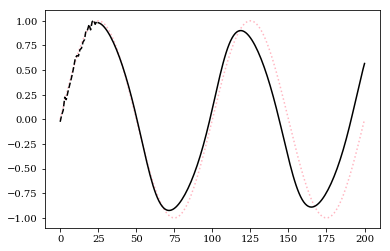

In [24]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()